<a href="https://colab.research.google.com/github/Arta-DS/Artamonova-Java/blob/main/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация по тональности

Предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

Часть 1.

# Анализ текстов


1.   Посчитайте количество отзывов в разных городах и на разные банки
2.   Постройте гистограмы длин слов в символах и в словах

3.   Найдите 10 самых частых:

*   слов
*   слов без стоп-слов

*   лемм
*   существительных

4.   Постройте кривые Ципфа и Хипса


5.   Ответьте на следующие вопросы:

*   какое слово встречается чаще, "сотрудник" или "клиент"?
*   сколько раз встречается слова "мошенничество" и "доверие"?

6.   В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  
t
f
−
i
d
f
, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)



Часть 2.

# Тематическое моделирование


1.   Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2.   Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.


Часть 3.

# Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1.   Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2.   Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.
3.   Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

*   1-ый вариант: (tf − idf) преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
*   2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.
В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.


Эта часть задания может быть сделана с использованием sklearn.

In [1]:
import json
import nltk
import bz2
import pandas as pd
import string
from collections import Counter
from nltk.corpus import stopwords
!pip install pymorphy3
from pymorphy3 import MorphAnalyzer
from functools import lru_cache
import matplotlib.pyplot as plt
import seaborn as sns
!pip install tqdm
from tqdm.auto import tqdm
!pip install gensim pyLDAvis
import gensim
from gensim import corpora
from gensim.models import LdaModel
from tqdm.auto import tqdm
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Phrases
!pip install pyldavis
import pyLDAvis.gensim_models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Импортируем модуль для загрузки файлов в Google Colab
from google.colab import files

# Загрузка файла через интерфейс Colab
uploaded = files.upload()

# Определяем имя загруженного файла
filename = next(iter(uploaded))  # автоматически определяем имя первого загруженного файла

# Обработка данных
responses = []
with bz2.open(filename, "rt") as f:
    for line in tqdm(f, desc="Processing"):
        try:
            resp = json.loads(line)
            if not resp.get('rating_not_checked', False) and len(resp.get('text', '').split()) > 0:
                responses.append(resp)
        except json.JSONDecodeError:
            continue  # Пропускаем битые строки

Saving banki_responses.json.bz2 to banki_responses.json.bz2


Processing: 0it [00:00, ?it/s]

# Анализ текста

In [3]:
df = pd.DataFrame(responses)
print("Первые 5 строк DataFrame:")
print(df.head())
print("\nКолонки DataFrame:", df.columns.tolist())

Первые 5 строк DataFrame:
             city  rating_not_checked  \
0       г. Москва               False   
1  г. Новосибирск               False   
2       г. Москва               False   
3   г. Ставрополь               False   
4    г. Челябинск               False   

                                               title  num_comments  \
0                                             Жалоба             0   
1      Не могу пользоваться услугой Сбербанк он-лайн             0   
2                    Двойное списание за один товар.             1   
3  Меняют проценты комиссии  не предупредив и не ...             2   
4             Верните денежные средства за страховку             1   

      bank_license       author        bank_name             datetime  \
0  лицензия № 2562       uhnov1          Бинбанк  2015-06-08 12:50:54   
1  лицензия № 1481       Foryou  Сбербанк России  2015-06-08 11:09:57   
2  лицензия № 2562   Vladimir84          Бинбанк  2015-06-05 20:14:28   
3  лицензия № 

1. Количество отзывов по городам и банкам

In [4]:
city_counts = df['city'].value_counts()
bank_counts = df['bank_name'].value_counts()
print("Количество отзывов по городам:\n", city_counts.head())
print("\nКоличество отзывов по банкам:\n", bank_counts.head())

Количество отзывов по городам:
 city
г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
Name: count, dtype: int64

Количество отзывов по банкам:
 bank_name
Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
Name: count, dtype: int64


<ipython-input-27-d7935916749b>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


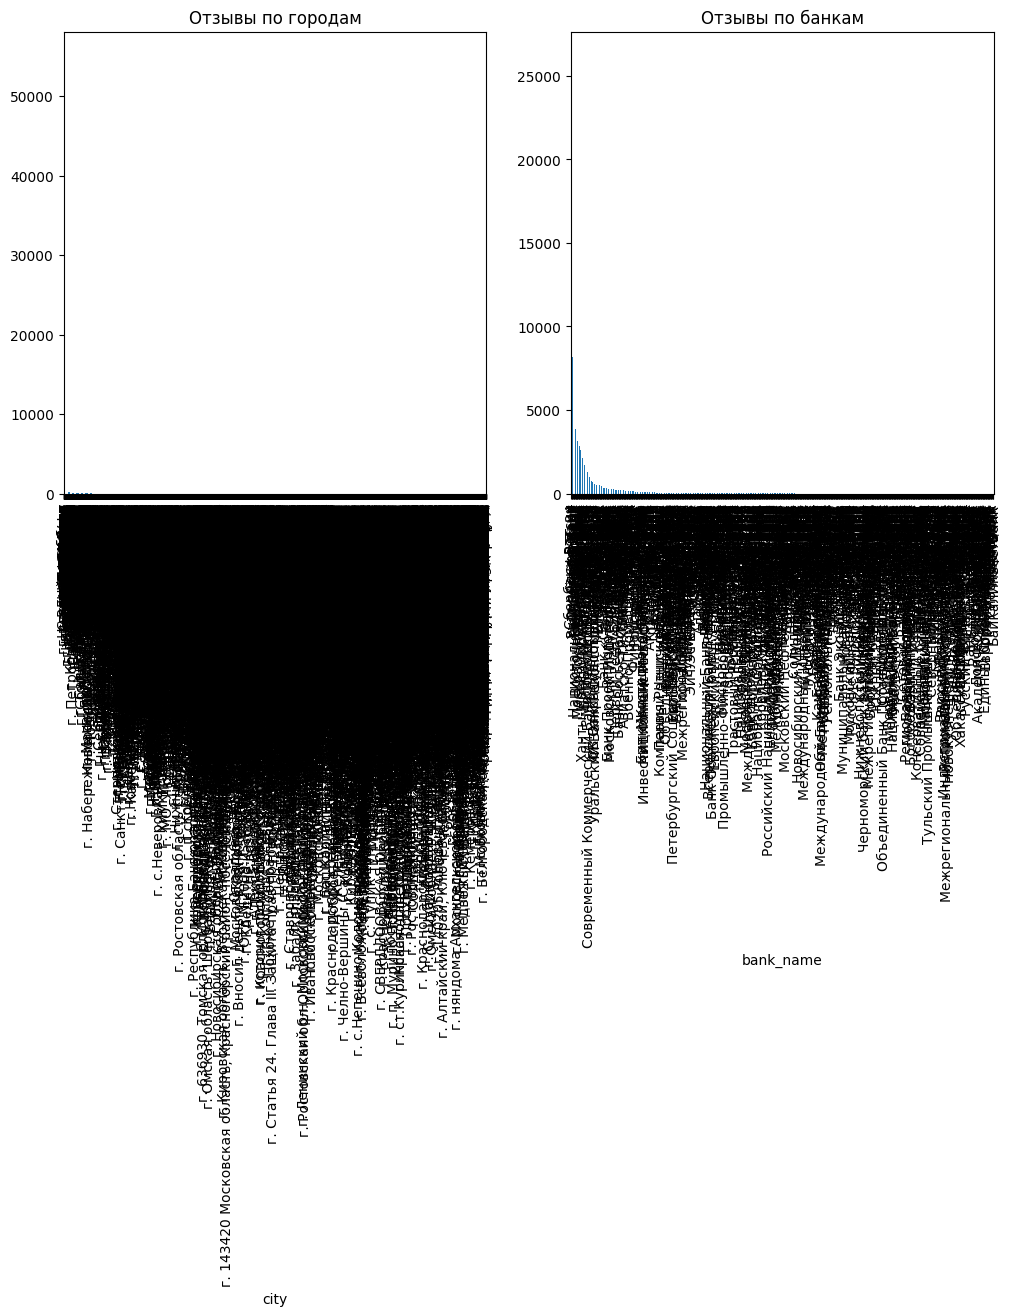

In [27]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
city_counts.plot(kind='bar', title='Отзывы по городам')
plt.subplot(1, 2, 2)
bank_counts.plot(kind='bar', title='Отзывы по банкам')
plt.tight_layout()
plt.show()

2. Гистограммы длин текстов

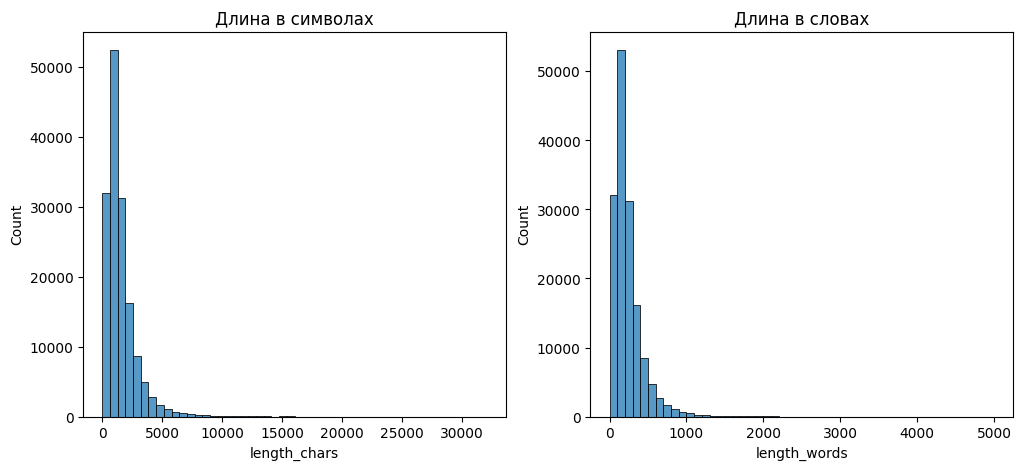

In [28]:
df['length_chars'] = df['text'].apply(len)
df['length_words'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['length_chars'], bins=50)
plt.title('Длина в символах')

plt.subplot(1, 2, 2)
sns.histplot(df['length_words'], bins=50)
plt.title('Длина в словах')
plt.show()

3. Самые частые элементы

In [5]:
# Инициализация
morph = MorphAnalyzer()
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# Предобработка текста
def preprocess(text):
    # Удаление пунктуации и приведение к нижнему регистру
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return text.split()

# Извлекаем все слова
all_words = [word for text in df['text'] for word in preprocess(text)]
# Фильтрация стоп-слов
filtered_words = [word for word in all_words if word not in russian_stopwords]

In [7]:
df_sample = df.sample(10000, random_state=42)  # Фиксируем random_state для воспроизводимости

In [8]:
@lru_cache(maxsize=100000)  # Кэшируем результаты лемматизации
def lemmatize(word):
    try:
        return morph.parse(word)[0].normal_form
    except:
        return word  # Возвращаем исходное слово в случае ошибки

In [9]:
# Обработка выборки
all_words = []
filtered_words = []
lemmas = []
nouns = []

for text in tqdm(df_sample['text'], desc="Обработка"):
    words = preprocess(text)
    for word in words:
        # Сбор всех слов
        all_words.append(word)

        # Фильтрация стоп-слов
        if word not in russian_stopwords:
            filtered_words.append(word)

        # Лемматизация
        lemma = lemmatize(word)
        lemmas.append(lemma)

        # Сбор существительных
        parsed = morph.parse(word)
        if parsed and 'NOUN' in parsed[0].tag:
            nouns.append(lemma)

print("Топ-10 слов:", Counter(all_words).most_common(10))
print("\nТоп-10 без стоп-слов:", Counter(filtered_words).most_common(10))
print("\nТоп-10 лемм:", Counter(lemmas).most_common(10))
print("\nТоп-10 существительных:", Counter(nouns).most_common(10))

Обработка:   0%|          | 0/10000 [00:01<?, ?it/s]

Топ-10 слов: [('в', 85390), ('и', 67968), ('не', 55209), ('на', 45158), ('что', 40360), ('я', 36615), ('с', 29688), ('по', 23459), ('мне', 20743), ('банка', 17094)]

Топ-10 без стоп-слов: [('банка', 17094), ('банк', 12693), ('это', 11760), ('деньги', 8324), ('карту', 6774), ('карты', 6475), ('кредит', 5007), ('день', 4854), ('заявление', 4463), ('время', 4374)]

Топ-10 лемм: [('в', 86658), ('я', 71451), ('и', 67968), ('не', 55209), ('на', 45158), ('что', 41780), ('банк', 40465), ('с', 33542), ('быть', 26988), ('по', 23459)]

Топ-10 существительных: [('банк', 40465), ('карта', 21618), ('деньга', 11393), ('день', 10945), ('кредит', 9600), ('отделение', 9166), ('счёт', 8822), ('клиент', 8693), ('сотрудник', 8589), ('сумма', 6925)]


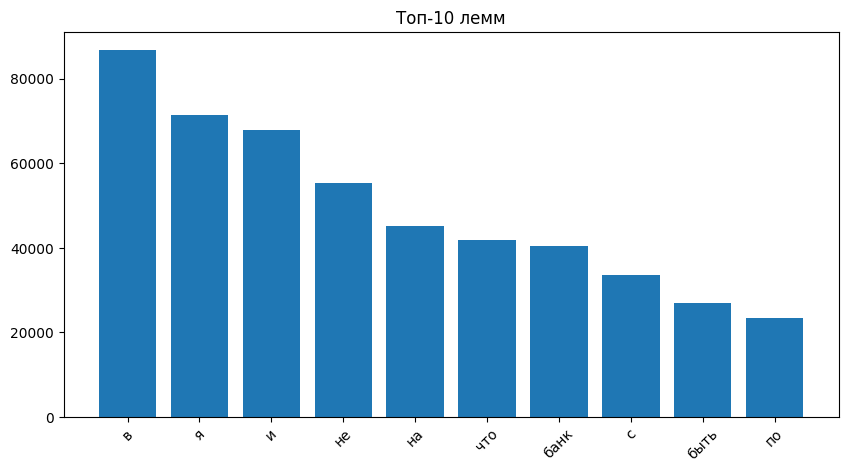

In [38]:
plt.figure(figsize=(10, 5))
plt.bar(*zip(*Counter(lemmas).most_common(10)))
plt.title('Топ-10 лемм')
plt.xticks(rotation=45)
plt.show()

4. Построим кривые Ципфа и Хипса

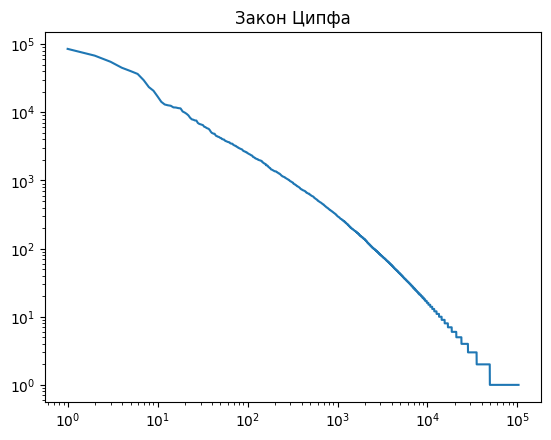

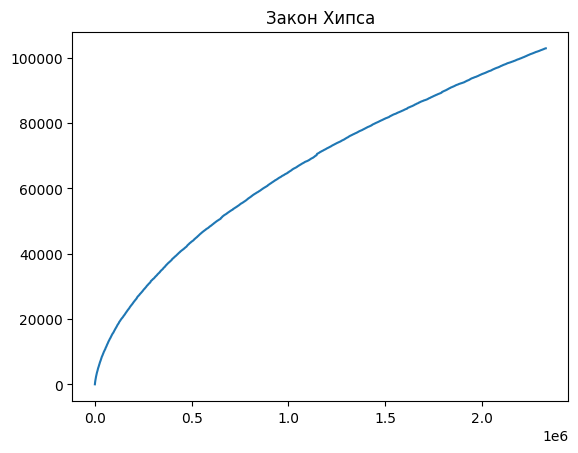

In [39]:
# Ципф
freq = list(Counter(all_words).values())
freq.sort(reverse=True)
plt.loglog(range(1, len(freq)+1), freq)
plt.title('Закон Ципфа')
plt.show()

# Хипс
unique_words = set()
counts = []
for word in all_words:
    unique_words.add(word)
    counts.append(len(unique_words))
plt.plot(counts)
plt.title('Закон Хипса')
plt.show()

5. Какое слово встречается чаще, "сотрудник" или "клиент"?

 Сколько раз встречаются слова "мошенничество" и "доверие"?

In [40]:
print("Сотрудник:", lemmas.count('сотрудник'))
print("Клиент:", lemmas.count('клиент'))
print("Мошенничество:", lemmas.count('мошенничество'))
print("Доверие:", lemmas.count('доверие'))

Сотрудник: 8589
Клиент: 8693
Мошенничество: 208
Доверие: 113


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру
t
f
−
i
d
f
, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [10]:
russian_stopwords_list = list(russian_stopwords)

# Инициализация TF-IDF с корректным форматом стоп-слов
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    stop_words=russian_stopwords_list,
    max_features=10000
)

# Применение TF-IDF ко всему набору данных
tfidf_matrix = tfidf.fit_transform(df['text'])

# Выделение TF-IDF для положительных и отрицательных отзывов
positive_indices = df[df['rating_grade'] == 5].index
negative_indices = df[df['rating_grade'] == 1].index

positive_tfidf = tfidf_matrix[positive_indices].mean(axis=0)
negative_tfidf = tfidf_matrix[negative_indices].mean(axis=0)

# Получение названий фич (слов и биграмм)
feature_names = tfidf.get_feature_names_out()

# Топ-10 ключевых терминов для положительных отзывов
top_positive = [
    feature_names[i]
    for i in positive_tfidf.argsort(axis=1)[0, -10:][::-1]
]

# Топ-10 ключевых терминов для отрицательных отзывов
top_negative = [
    feature_names[i]
    for i in negative_tfidf.argsort(axis=1)[0, -10:][::-1]
]

print("Ключевые термины для положительных отзывов (оценка 5):")
print(top_positive)

print("\nКлючевые термины для отрицательных отзывов (оценка 1):")
print(top_negative)

Ключевые термины для положительных отзывов (оценка 5):
[array([['карту', 'банке', 'кредит', 'вклад', 'быстро', 'это', 'спасибо',
        'банк', 'банка', 'очень']], dtype=object)]

Ключевые термины для отрицательных отзывов (оценка 1):
[array([['счет', 'кредит', 'отделение', 'заявление', 'карты', 'карту',
        'это', 'деньги', 'банк', 'банка']], dtype=object)]


# Часть 2. Тематическое моделирование

1. Подготовка данных

In [11]:
df_subsample = df.sample(frac=0.2, random_state=42)  # 20% от исходного датасета

# Оптимизированная предобработка
def preprocess(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    tokens = text.split()
    # Удаляем стоп-слова ДО лемматизации (экономия ресурсов)
    tokens = [word for word in tokens if word not in russian_stopwords]
    return tokens

# Лемматизация с ограничением на частоту слов
def lemmatize_word(word):
    return morph.parse(word)[0].normal_form

# Применение предобработки к подвыборке
processed_texts = []
for text in tqdm(df_subsample['text'], desc="Предобработка"):
    tokens = preprocess(text)
    lemmas = [lemmatize_word(word) for word in tokens]
    processed_texts.append(lemmas)

# Фильтрация словаря
protected_words = {'сбербанк', 'втб', 'альфа', 'тинькофф', 'газпромбанк'}

dictionary = corpora.Dictionary(processed_texts)
dictionary.filter_extremes(
    no_below=2,
    no_above=0.9,
    keep_tokens=protected_words
)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Обучение LDA с оптимизацией
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=5,
    iterations=100,
    random_state=42,
    chunksize=1000
)

# Анализ тем
def analyze_topics(model, top_words=10):
    topics = model.show_topics(num_topics=-1, num_words=top_words, formatted=False)
    for topic_id, words in topics:
        print(f"Тема {topic_id}: {[word for word, _ in words]}")

analyze_topics(lda_model)

Предобработка:   0%|          | 0/30700 [00:00<?, ?it/s]

Тема 0: ['банк', 'сотрудник', 'мой', 'телефон', 'номер', 'звонок', 'ваш', 'звонить', 'который', 'клиент']
Тема 1: ['договор', 'банк', 'условие', 'страховка', 'кредитный', 'страхование', 'право', 'услуга', 'который', 'страховой']
Тема 2: ['банк', 'платёж', 'операция', 'проблема', 'услуга', 'система', 'поддержка', 'служба', 'карта', 'это']
Тема 3: ['деньга', 'банкомат', 'день', 'снять', 'сказать', 'терминал', 'сумма', 'отделение', 'выдать', 'чек']
Тема 4: ['кредит', 'банк', 'платёж', 'сумма', 'кредитный', 'задолженность', 'год', 'месяц', 'погашение', 'руб']
Тема 5: ['карта', 'банк', 'отделение', 'это', 'кредитный', 'сказать', 'день', 'лимит', 'получить', 'заявление']
Тема 6: ['банк', 'вклад', 'клиент', 'это', 'отделение', 'офис', 'очередь', 'очень', 'время', 'работать']
Тема 7: ['это', 'сказать', 'говорить', 'деньга', 'девушка', 'мочь', 'такой', 'звонить', 'знать', 'просто']
Тема 8: ['счёт', 'банк', 'заявление', 'средство', 'мой', 'день', 'сбербанк', 'деньга', 'отделение', 'сумма']
Тема 

In [30]:
# Проверка упоминаний в топ-50 словах
bank_keywords = ['сбербанк', 'втб', 'альфа', 'альфа_банк', 'альфа-банк', 'тинькофф', 'газпромбанк']

for topic_id in range(10):
    print(f"\nТема {topic_id}:")
    words = [word for word, _ in lda_model.show_topic(topic_id, topn=50)]
    found_banks = [word for word in words if word in bank_keywords]
    print(f"Найдены банки: {', '.join(found_banks)}" if found_banks else "Банки не обнаружены")


Тема 0:
Банки не обнаружены

Тема 1:
Найдены банки: сбербанк

Тема 2:
Банки не обнаружены

Тема 3:
Банки не обнаружены

Тема 4:
Банки не обнаружены

Тема 5:
Банки не обнаружены

Тема 6:
Банки не обнаружены

Тема 7:
Банки не обнаружены

Тема 8:
Найдены банки: сбербанк

Тема 9:
Банки не обнаружены


In [14]:
# Подсчет упоминаний защищенных слов в обработанных текстах
from collections import defaultdict

bank_counts = defaultdict(int)
for text in processed_texts:
    for word in text:
        if word in protected_words:
            bank_counts[word] += 1

print("Частота упоминаний банков:", dict(bank_counts))

Частота упоминаний банков: {'альфа': 1176, 'сбербанк': 12725, 'втб': 1485, 'тинькофф': 481, 'газпромбанк': 173}


In [15]:
# Проверка первых 10 текстов
print("Пример обработанных текстов:")
for text in processed_texts[:10]:
    print([word for word in text if word in protected_words])

Пример обработанных текстов:
['альфа', 'альфа']
[]
[]
[]
['альфа']
[]
[]
[]
[]
[]


In [16]:
print(morph.parse('ВТБ')[0].normal_form)  # Должно быть 'втб'
print(morph.parse('Альфа-Банк')[0].normal_form)  # Должно быть 'альфа_банк'

втб
альфа-банк


In [18]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

In [19]:
protected_words = {'сбербанк', 'втб', 'альфа', 'альфа_банк', 'тинькофф', 'газпромбанк'}

In [20]:
# Обработка биграмм
bigram = Phrases(processed_texts, min_count=2)
processed_texts = [bigram[line] for line in processed_texts]

# Пересоздание словаря и корпуса
dictionary = corpora.Dictionary(processed_texts)
dictionary.filter_extremes(
    no_below=2,
    no_above=0.9,
    keep_tokens=protected_words  # Обновленный список защищенных слов
)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Повторное обучение LDA
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=5,
    iterations=100,
    random_state=42,
    chunksize=1000
)

# Проверка упоминаний банков
for topic_id in range(10):
    print(f"\nТема {topic_id}:")
    words = [word for word, _ in lda_model.show_topic(topic_id, topn=50)]
    found_banks = [word for word in words if word in protected_words]
    print(f"Найдены банки: {', '.join(found_banks)}" if found_banks else "Банки не обнаружены")

# Визуализация
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


Тема 0:
Банки не обнаружены

Тема 1:
Найдены банки: сбербанк

Тема 2:
Банки не обнаружены

Тема 3:
Банки не обнаружены

Тема 4:
Банки не обнаружены

Тема 5:
Банки не обнаружены

Тема 6:
Банки не обнаружены

Тема 7:
Банки не обнаружены

Тема 8:
Найдены банки: сбербанк

Тема 9:
Банки не обнаружены


# Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных
n
-грам.
Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант:
t
f
−
i
d
f
 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.
В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

Фильтрация данных (отзывы с оценками 1 и 5)

In [21]:
# Отбираем только отзывы с оценками 1 и 5
df_filtered = df[df['rating_grade'].isin([1, 5])]

# Балансировка классов (по 1000 отзывов каждого класса)
n_samples = 1000
df_balanced = pd.concat([
    df_filtered[df_filtered['rating_grade'] == 1].sample(n_samples, random_state=42),
    df_filtered[df_filtered['rating_grade'] == 5].sample(n_samples, random_state=42)
])

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['text'],
    df_balanced['rating_grade'],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['rating_grade']
)

Классификация с использованием TF-IDF + LSI

In [22]:
# Pipeline с TF-IDF и LSI
pipeline_tfidf_lsi = Pipeline([
    ('vect', CountVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        stop_words=list(russian_stopwords)
    )),
    ('tfidf', TfidfTransformer()),
    ('lsi', TruncatedSVD(n_components=100)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Обучение и оценка
pipeline_tfidf_lsi.fit(X_train, y_train)
y_pred = pipeline_tfidf_lsi.predict(X_test)

print("TF-IDF + LSI:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.3f}")

TF-IDF + LSI:
Accuracy: 0.875
F1-score: 0.875


Классификация с использованием LDA

In [23]:
# Pipeline с LDA
pipeline_lda = Pipeline([
    ('vect', CountVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        stop_words=list(russian_stopwords)
    )),
    ('lda', LatentDirichletAllocation(n_components=50, random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Обучение и оценка
pipeline_lda.fit(X_train, y_train)
y_pred = pipeline_lda.predict(X_test)

print("LDA:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.3f}")

LDA:
Accuracy: 0.825
F1-score: 0.823


Эксперимент с символьными n-граммами

In [82]:
# Pipeline с символьными n-граммами
pipeline_char = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(3, 5), max_features=10000)),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(random_state=42))
])

Наиболее важные признаки для класса 5: [(0.7964498447692421, 'спас'), (0.7959085933404201, ' прия'), (0.7950557720519142, ' спас'), (0.779824804195393, 'спаси'), (0.779824804195393, 'пасиб'), (0.779824804195393, 'асибо'), (0.779824804195393, 'асиб'), (0.7788907864757194, 'сибо'), (0.7748886981786571, 'паси'), (0.7713849851022149, 'спа'), (0.7439744107084741, ' спа'), (0.741996581476263, 'сиб'), (0.7417079116888523, ' и '), (0.7276350542995016, 'но '), (0.7006750229366504, 'риятн'), (0.7006750229366504, 'иятн'), (0.6870999384408756, ' дов'), (0.6870441017304095, 'сибо '), (0.6828683041251924, 'рият'), (0.6828683041251924, 'прият')]


In [27]:
pipeline_char.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(analyzer='char', max_features=10000,
                                 ngram_range=(3, 5))),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(random_state=42))])

In [28]:
vectorizer = pipeline_char.named_steps['vect']
clf = pipeline_char.named_steps['clf']
feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_[0]  # Для бинарной классификации

top_features = sorted(zip(coefs, feature_names), reverse=True)[:20]
print("Наиболее важные признаки для класса 5:", top_features)

Наиболее важные признаки для класса 5: [(0.7964498447692421, 'спас'), (0.7959085933404201, ' прия'), (0.7950557720519142, ' спас'), (0.779824804195393, 'спаси'), (0.779824804195393, 'пасиб'), (0.779824804195393, 'асибо'), (0.779824804195393, 'асиб'), (0.7788907864757194, 'сибо'), (0.7748886981786571, 'паси'), (0.7713849851022149, 'спа'), (0.7439744107084741, ' спа'), (0.741996581476263, 'сиб'), (0.7417079116888523, ' и '), (0.7276350542995016, 'но '), (0.7006750229366504, 'риятн'), (0.7006750229366504, 'иятн'), (0.6870999384408756, ' дов'), (0.6870441017304095, 'сибо '), (0.6828683041251924, 'рият'), (0.6828683041251924, 'прият')]


In [29]:
top_negative_features = sorted(zip(clf.coef_[0], feature_names))[:20]
print("Наиболее важные признаки для класса 1:", top_negative_features)

Наиболее важные признаки для класса 1: [(-1.2134986263598957, ' не'), (-0.9424975835995032, ' не '), (-0.9351479028369674, 'не '), (-0.775625405771574, '...'), (-0.7327040017968512, 'пре'), (-0.7245611898518471, 'руб'), (-0.6818097971702364, ' я '), (-0.6810254920397335, 'отв'), (-0.6630087555607435, 'не мо'), (-0.6482546425012232, ': "'), (-0.6465295383092722, ' не м'), (-0.6460056971995474, '... '), (-0.6216971130391834, ' их'), (-0.6177442461195719, '.. '), (-0.6143077813141764, ' ваш'), (-0.6071911466069657, 'ваш'), (-0.5946558576355833, 'не м'), (-0.5924553755566797, 'отказ'), (-0.5924553755566797, 'тказ'), (-0.5918129178269104, ' нев')]
